In [1]:
import importlib
import concept_generalization
importlib.reload(concept_generalization)
from concept_generalization import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

---

## Useful Functions

In [4]:
def collect_clusterPredictions(hidden_dim, activation_type, center_list, var_list, test_centers, test_vars, target_fn=None, loss_n=[], n_test=5, k=1, lo=10, hi=100, step=1, learning_rate=0.001, printOutput=False):
    """
    Collect predictions of model on test set over values of n (num_samples) between lo and hi. 
    Also collect (averaged over k) training loss history models trained on each of loss_n samples.

    Inputs:
    - hidden_dim: List containing number of hidden neurons per layer
    - activation_type: {'linear', 'ReLU}
    - center_list: List of d-dimensional vectors representing the mean of Gaussian train clusters.
    - var_list (list of dxd covariance matrices): List of dxd matrices representing the covariance for Gaussian train clusters.
    - test_centers: List of d-dimensional centers of Gaussian test clusters
    - test_vars (list of dxd covariance matrices): List of dxd matrices representing the covariance for Gaussian test clusters.
    - target_fn: Function mapping sample points to target points (defaults to identity map)
    - loss_n (List): Sorted list of n's for which we collect loss histories
    - n_test (int): number of test points sampled from each test cluster
    - k (int): number of predictions/models trained for each choice of n
    - lo (int): min n
    - hi (int): max n
    - step (int): intervals of n

    Returns:
    - evals (n_sizes x k x n_testPoints x dim): Array of all model predictions (over lo <= n < hi) for each test point
    - losses: List (ragged in dim 2) of all training loss histories for each n in loss_n
    - test_points: List of sampled test points (n_test from each cluster)
    """
    evals = []
    losses = []
    loss_pointer = 0
    # sample test points
    test_points = sampling(test_centers, test_vars, n_test)

    for i in range(lo,hi,step):
        curr_losses = []    # store loss histories of curr n if n in loss_n
        curr_tests = []
        for j in range(k):
            print("on iteration", j, " of k=", k)
            samples = sampling(center_list, var_list, i)    # n_testPoints x 3
            # Train the MLP
            if target_fn is None:
                train_targets = []
            else:
                train_targets = target_fn(samples)
            trained_model, loss_history, _ = train_mlp(samples, hidden_dim, activation_type, targets=train_targets, test_samples=[], max_epochs=10000, learning_rate=learning_rate, printOutput=printOutput)
            predictions = test_model(trained_model, test_points, printOutput=False) # n_testPoints x 3
            curr_tests.append(predictions)
            if i == loss_n[loss_pointer]:
                curr_losses.append(loss_history)
        if i == loss_n[loss_pointer]: 
            if loss_pointer + 1 < len(loss_n):
                loss_pointer += 1
            losses.append(curr_losses)  # curr_losses is k x len(loss_history) <- ragged
        evals.append(curr_tests)    # curr_tests is k x n_testPoints x 3
        
    return np.array(evals), test_points, losses


In [6]:
def compute_clusterLoss(evals, test_targets, test_centers, n_test):
    """
    Compute test loss averaged over points sampled from each test cluster over num training samples.

    Inputs:
    - evals (np.array): Array (n_sizes x k x n_testPoints x dim) of all model predictions (over lo <= n < hi) for each test point
    - test_targets (List): List of all test targets
    - test_centers (List): List of centers of all test clusters
    - n_test (int): number of test points sampled from each test cluster

    Output: 
    - loss_list (np.array): Array (len(test_centers) x n_sizes) of average test loss in each cluster
    """
    n_sizes = len(evals)
    k = len(evals[0])
    n_testPoints = len(evals[0][0]) # total number of test points = n_test x len(test_centers)
    n_testCenters = len(test_centers)
    
    loss_list = [[] for _ in range(n_testCenters)] # store avg prediction loss per test cluster
    for test_idx in range(n_testPoints):
        cluster_idx = test_idx // n_test    # idx of curr test cluster
        test_target = test_targets[test_idx]
        test_eval = evals[:,:,test_idx] # n_sizes x k x 3
        print('test_idx =', test_idx)
        print('test_eval =', test_eval)
        print('test_eval.shape =', np.array(test_eval).shape)
        print('test_target =', np.array([np.vstack([test_target] * k)] * n_sizes))
        print('test_target.shape =', np.array([np.vstack([test_target] * k)] * n_sizes).shape)
        loss = np.sum(np.square(test_eval - np.array([np.vstack([test_target] * k)] * n_sizes)), axis=2) # n_sizes x k
        loss_list[cluster_idx].append(np.mean(loss, axis=1)) #  loss_list after for loop: len(test_centers) x n_test x n_sizes
    loss_list = np.mean(loss_list, axis=1)  # len(test_centers) x n_sizes
    return loss_list

In [7]:
def plot_clusterTestLoss(loss_list, test_centers, hidden_dim, activation_type='ReLU', lo=10, hi=100, step=5, labels=10):
    """
    Plot test loss averaged over points sampled from each test cluster over num training samples.

    Inputs:
    - loss_list (np.array): Array (len(test_centers) x n_sizes) of average test loss in each cluster
    - test_centers (List): List of centers of all test clusters
    - hidden_dim: List containing number of hidden neurons per layer
    - activation_type: {'linear', 'ReLU}
    - lo (int): min n
    - hi (int): max n
    - step (int): intervals of n
    - labels (int): Interval of labels for x axis
    """
    n_testCenters = len(test_centers)
    for cluster_idx in range(n_testCenters):
        plt.plot(loss_list[cluster_idx])
    
    plt.xlabel('n = num_samples')
    plt.ylabel('Test Loss')
    plt.title('Test loss over Num samples (hidden_dim = %s, ' % hidden_dim + activation_type + ')')
    plt.legend([''.join(map(str, test_centers[cluster_idx])) for cluster_idx in range(n_testCenters)])
    plt.xticks(np.arange(lo - 10, hi, labels)/step)
    plt.xticks(np.arange(lo - 10, hi, labels)/step, 10 + np.arange(lo - 10, hi, labels))
    plt.grid(True)
    plt.show()

In [8]:
def scatter_testPredictions(evals, test_targets, hidden_dim, test_ids, n_test=10, activation_type='ReLU', k=1, lim=True):
    """
    Scatter plot of test predictions for varying num training samples.

    Inputs:
    - evals (np.array): Array (n_sizes x k x n_testPoints x dim) of all model predictions (over lo <= n < hi) for each test point
    - test_targets (List): List of all test targets
    - hidden_dim: List containing number of hidden neurons per layer
    - test_ids: List of test indices to plot
    - n_test (int): number of test points sampled from each test cluster
    - activation_type: {'linear', 'ReLU}
    - k (int): number of predictions/models trained for each choice of n
    """
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    evals = np.array(evals)

    # plot each corner
    test_idList = np.ravel([id * n_test + np.arange(n_test) for id in test_ids])
    #print(test_idList)
    print(evals.shape)
    for test_idx in test_idList:
        # read out predictions for each test point
        test_evals = evals[:, :, test_idx] # n_sizes x k x dim
        #print(test_evals.shape)
        ax.scatter(test_evals[:, :, 0], test_evals[:, :, 1], test_evals[:, :, 2], c=np.arange(len(test_evals)*k, 0, -1), s=10, zorder=1)
        # plot tes point itself
        ax.scatter(test_targets[test_idx, 0], test_targets[test_idx, 1], test_targets[test_idx, 2], c='r', s=20, zorder=2)

    if lim:
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)
        ax.set_zlim(-0.1, 1.1)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    plt.title('Test loss over Num samples (hidden_dim = %s, ' % hidden_dim + activation_type + ')')
    plt.show()

In [9]:
def plot_trainingLoss(losses, loss_n, plot_list, hidden_dim, activation_type='ReLU', k=1, hi=100):
    """
    Plot a random training loss history from one of k models trained on n train samples for each n in plot_list.

    Inputs:
    - losses (List): List (len(loss_n) x k x len(loss_history)) of loss histories for all k models trained on n samples for n in loss_n
    - loss_n (List): Sorted list of n's for which we collect loss histories
    - plot_list (List): subset of indices in loss_n for which to actually plot loss histories
    - hidden_dim: List containing number of hidden neurons per layer
    - activation_type: {'linear', 'ReLU}
    - k (int): number of predictions/models trained for each choice of n
    """
    n_plots = len(plot_list)
    for loss_idx in plot_list:
        plt.plot(losses[loss_idx][np.random.randint(0, k)])
    
    plt.xlabel('epochs')
    plt.ylabel('Training Loss')
    plt.xlim(0, hi)
    plt.title('Training loss over epochs (hidden_dim = %s, ' % hidden_dim + activation_type + ')')
    plt.legend(['n= % d' % loss_n[loss_idx] for loss_idx in plot_list])
    plt.grid(True)
    plt.show()

In [10]:
def plot_hiddDim(testLoss_list, test_centers, hidd_list, activation_type='ReLU', lo=100):
    n_testCenters = len(test_centers)
    for t in range(n_testCenters):
        plt.plot(hidd_list, testLoss_list[:, t])

    plt.xlabel('hidden_dim')
    plt.ylabel('test loss')
    plt.title('Test loss over hidden_dim (n = %s, ' % lo + activation_type + ')')
    plt.legend([''.join(map(str, test_centers[cluster_idx])) for cluster_idx in range(n_testCenters)])
    plt.xscale('log')
    plt.grid(True)
    plt.show()

---

In [3]:
importlib.reload(concept_generalization)
from concept_generalization import *

## non-identity map

In [11]:
# define mapping from samples to targets
def flippedIdentity(samples):
    out = []
    for sample in samples:
        if np.sum(sample) < 1.5: out.append(np.array(sample))
        else: out.append(1-np.array(sample))
    return np.array(out)

In [ ]:
print(flippedIdentity([[0,0,0], [0,0,1], [0,1,0], [1,0,0], [0,1,1], [1,0,1], [1,1,0], [1,1,1]]))

In [12]:
center_list = [[0,0,0], [0,0,1], [0,1,0], [1,0,0], [0,1,1], [1,0,1], [1,1,0], [1,1,1]]
var_list = [ [[0.01, 0, 0], [0, 0.01, 0], [0, 0, 0.01] ]]*8
test_centers = [[0,0,0], [0,0,1], [0,1,0], [1,0,0], [0,1,1], [1,0,1], [1,1,0], [1,1,1]]
test_vars = [ [[0.001, 0, 0], [0, 0.001, 0], [0, 0, 0.001] ]]*8
hidd_list = [128, 256, 512, 1024, 2048]
n_hiddDim = len(hidd_list)
n_test = 20


k, lo, hi, step = 10, 100, 110, 10
loss_n = range(lo, hi, step)

In [13]:
eval_list = [[] for _ in range(n_hiddDim)]  # list of test evaluations
losses_list = [[] for _ in range(n_hiddDim)]    # list of training loss histories

In [ ]:
hidden_dim, activation_type = [hidd_list[0]], 'ReLU'
evals, test_points, losses = collect_clusterPredictions(hidden_dim, activation_type, center_list, var_list, test_centers, test_vars, target_fn=flippedIdentity, loss_n=loss_n, n_test=n_test, k=k, lo=lo, hi=hi, step=step, printOutput=False)
eval_list[0] = evals
losses_list[0] = losses

In [ ]:
hidden_dim, activation_type = [hidd_list[1]], 'ReLU'
evals, test_points, losses = collect_clusterPredictions(hidden_dim, activation_type, center_list, var_list, test_centers, test_vars, target_fn=flippedIdentity, loss_n=loss_n, n_test=n_test, k=k, lo=lo, hi=hi, step=step, printOutput=False)
eval_list[1] = evals
losses_list[1] = losses

In [ ]:
hidden_dim, activation_type = [hidd_list[2]], 'ReLU'
evals, test_points, losses = collect_clusterPredictions(hidden_dim, activation_type, center_list, var_list, test_centers, test_vars, target_fn=flippedIdentity, loss_n=loss_n, n_test=n_test, k=k, lo=lo, hi=hi, step=step, printOutput=False)
eval_list[2] = evals
losses_list[2] = losses

In [ ]:
hidden_dim, activation_type = [hidd_list[3]], 'ReLU'
evals, test_points, losses = collect_clusterPredictions(hidden_dim, activation_type, center_list, var_list, test_centers, test_vars, target_fn=flippedIdentity, loss_n=loss_n, n_test=n_test, k=k, lo=lo, hi=hi, step=step, printOutput=False)
eval_list[3] = evals
losses_list[3] = losses
print(np.array(eval_list[3]).shape)

In [ ]:
hidden_dim, activation_type = [hidd_list[4]], 'ReLU'
evals, test_points, losses = collect_clusterPredictions(hidden_dim, activation_type, center_list, var_list, test_centers, test_vars, target_fn=flippedIdentity, loss_n=loss_n, n_test=n_test, k=k, lo=lo, hi=hi, step=step, printOutput=False)
eval_list[4] = evals
losses_list[4] = losses

(1, 10, 160, 3)


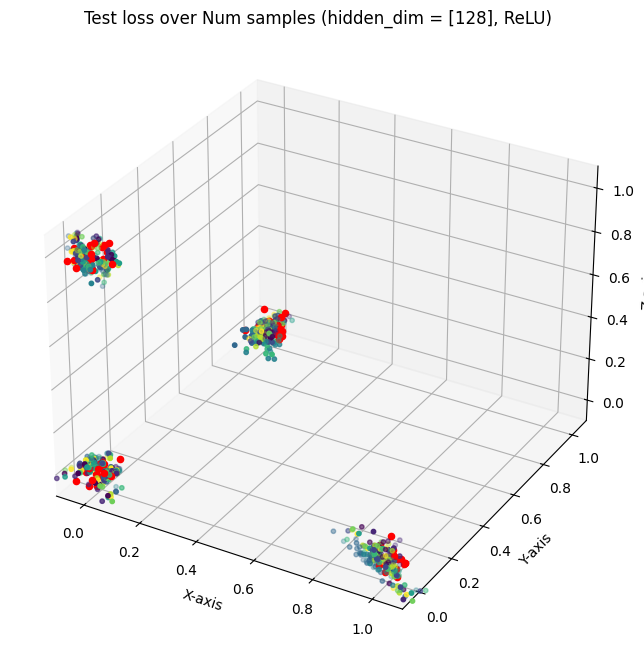

(1, 10, 160, 3)


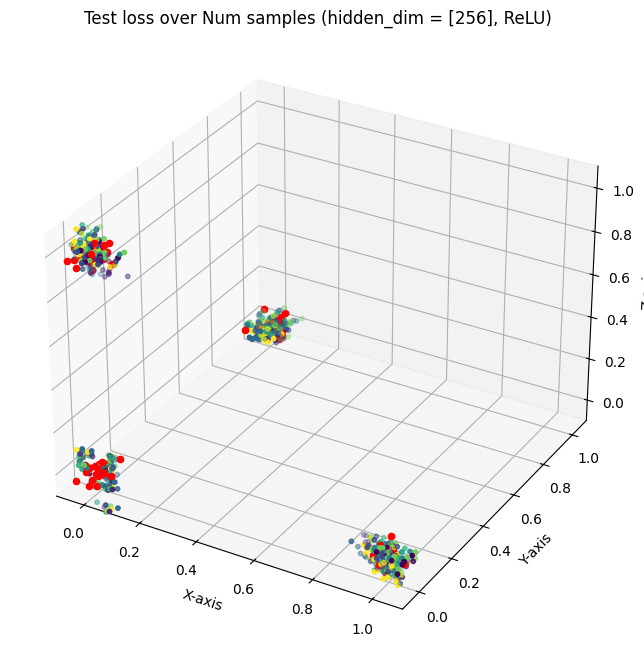

(1, 10, 160, 3)


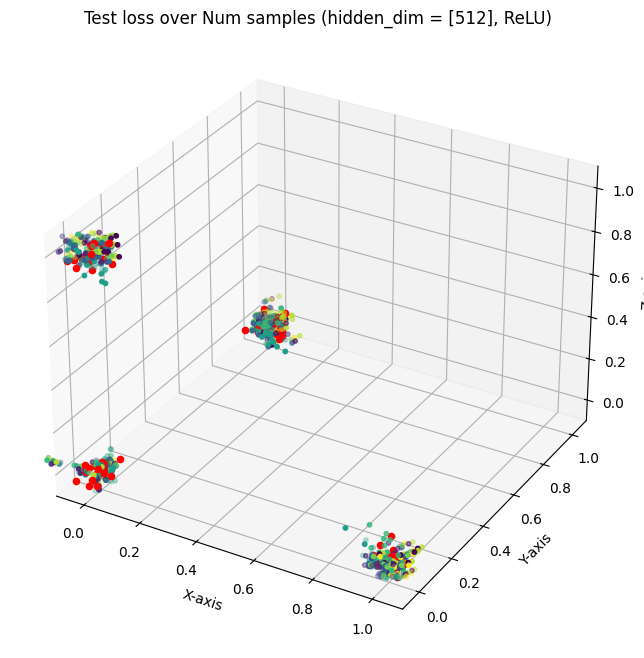

(1, 10, 160, 3)


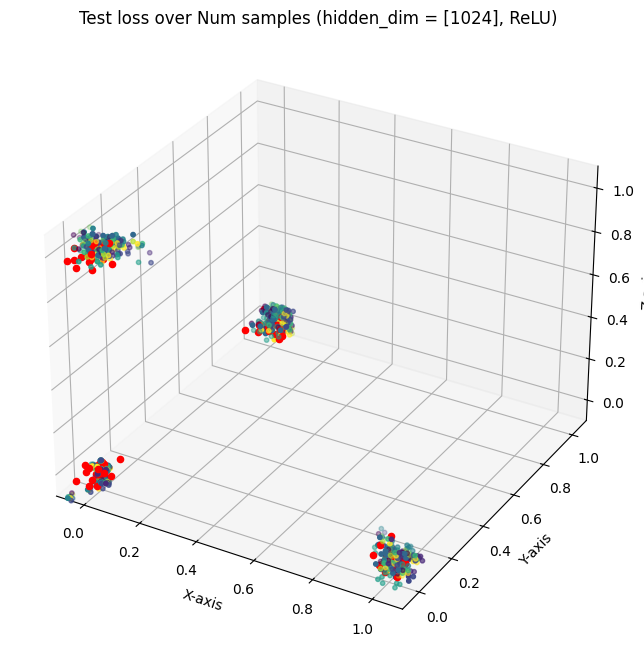

In [30]:
for i in range(4):
    scatter_testPredictions(eval_list[i], test_points, hidden_dim=[hidd_list[i]], test_ids=range(4), n_test=n_test, k=k)

(1, 10, 160, 3)


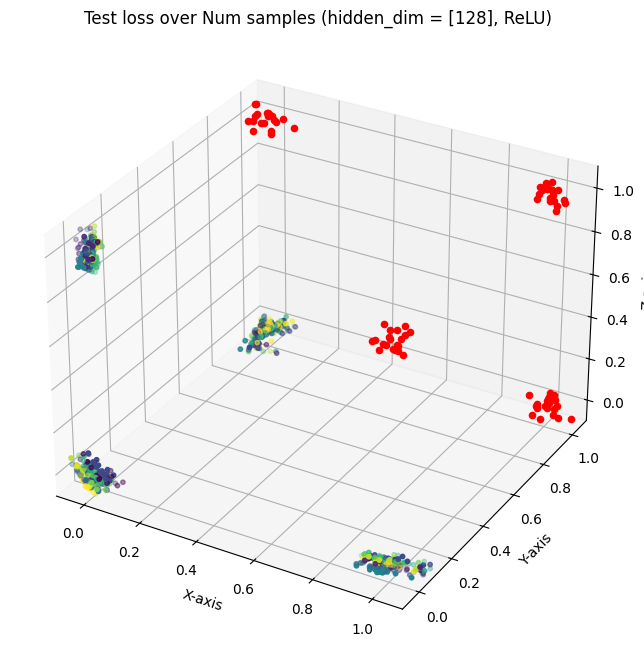

(1, 10, 160, 3)


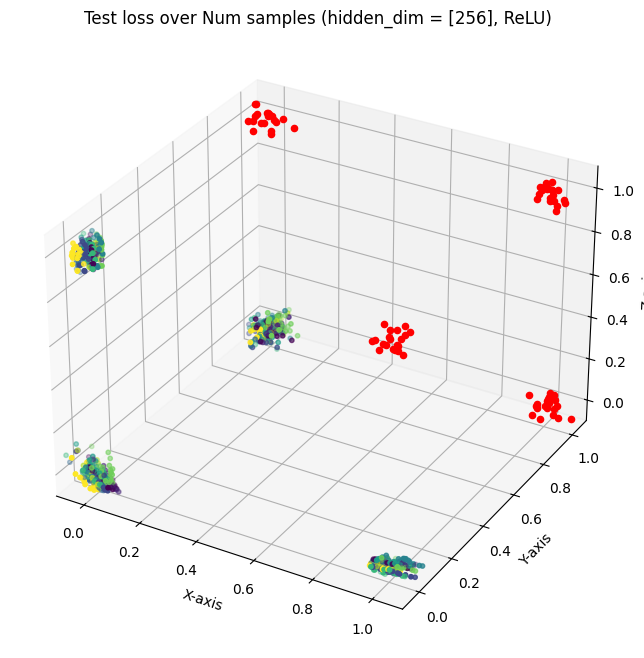

(1, 10, 160, 3)


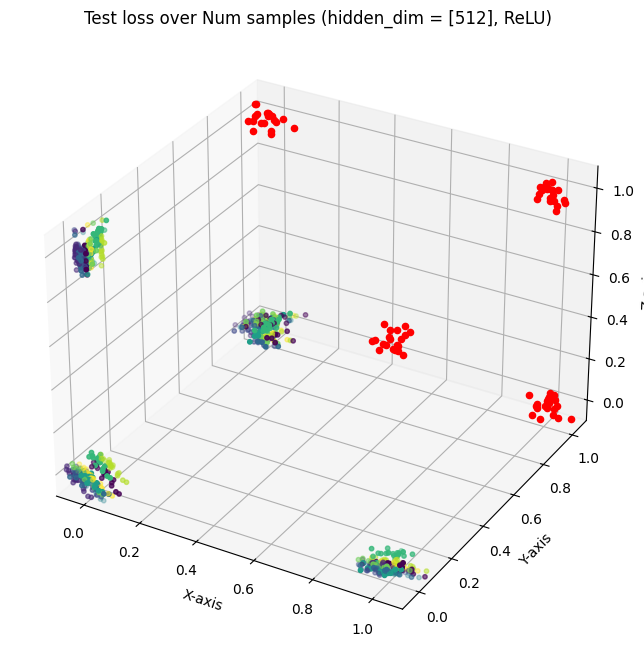

(1, 10, 160, 3)


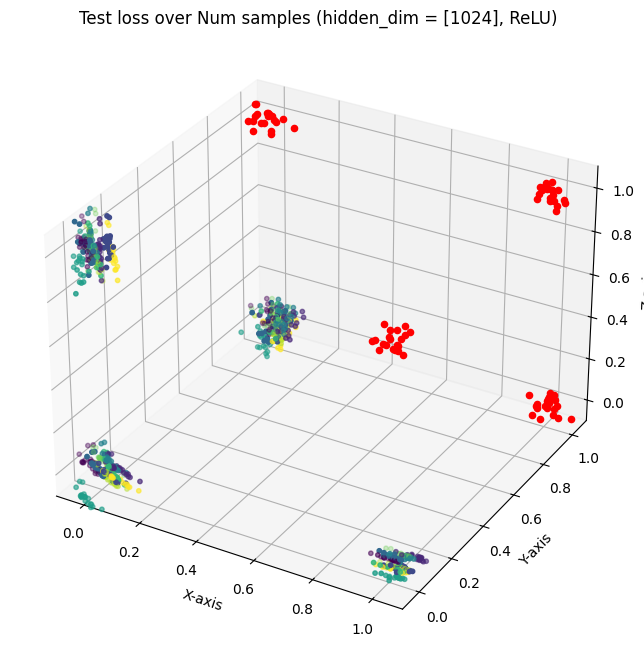

In [31]:
for i in range(4):
    scatter_testPredictions(eval_list[i], test_points, hidden_dim=[hidd_list[i]], test_ids=range(4, 8), n_test=n_test, k=k)

In [ ]:
print(len(losses_list))    # n_hiddDim x 1 x k x len(loss_history)
print(len(losses_list[0]))
print(len(losses_list[0][0]))
for t in range(5):
    plt.plot(losses_list[t][0][np.random.randint(0, k)])
#for losses in losses_list:
#    plt.plot(losses[0][np.random.randint(0, k)])

plt.xlabel('epochs')
plt.xlim(0, 1000)
plt.ylabel('Training Loss')
plt.title('Training loss over epochs (n = %s, ' % lo + activation_type + ')')
plt.legend(['hidd_dim= % d' % hidd_list[t] for t in range(n_hiddDim)])
plt.grid(True)
plt.show()

In [ ]:
testLoss_list = [[] for _ in range(5)]  # list of avg test losses at each cluster
#print(np.array(eval_list).shape)
for i in range(5):
    testLoss = compute_clusterLoss(eval_list[i], flippedIdentity(test_points), test_centers, n_test)
    #print(testLoss.shape)
    #print(testLoss)
    testLoss_list[i] = np.reshape(testLoss, (8))
testLoss_list = np.array(testLoss_list)

In [ ]:
plot_hiddDim(testLoss_list, test_centers, hidd_list[:5], lo=100)